In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from collections import defaultdict, Counter

## DMS single mutant effects on affinity

In [2]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


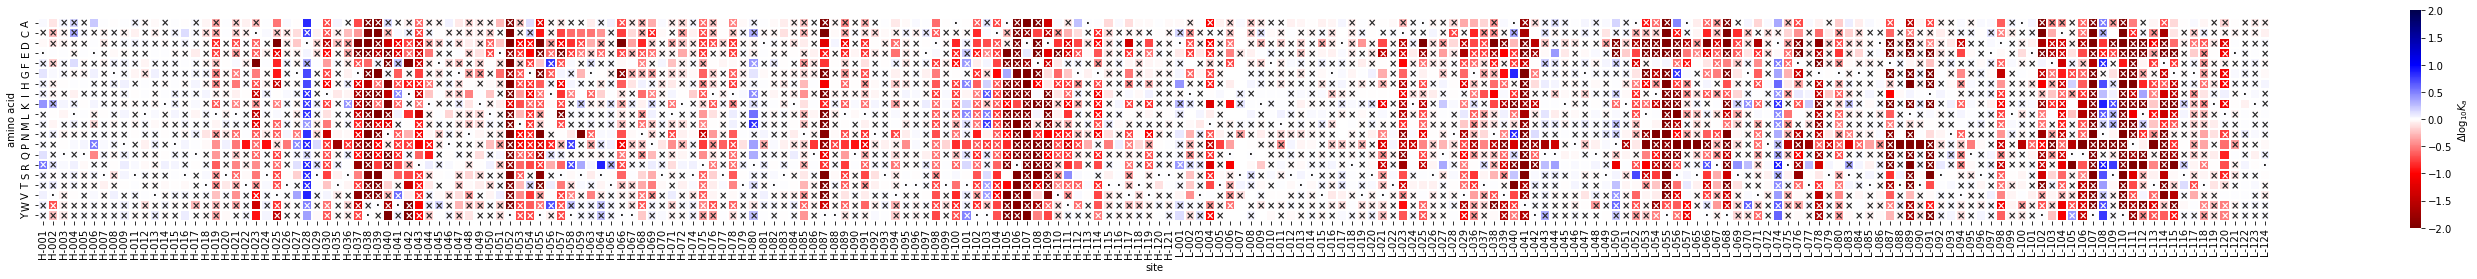

In [3]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = 2
vmin = -2

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

## Mutations in GC trees

In [4]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-03-28'

In [5]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), PR_str[3] + "-" + PR_str[2]

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


In [6]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")

## Codon-wise first step mutations

In [98]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

# hits_df.values[wt_df.values] = np.nan
# hits_df.values[~accessible_df.values.astype(bool)] = np.nan

for gc, tree in trees.items():
    already_hit = defaultdict(set)
    for node in tree.tree.traverse(strategy="preorder"):
        if not node.is_root():
            already_hit[node] = already_hit[node.up].copy()
            already_hit[node].update((mutation[:-1] for mutation in node.mutations))
        for mutation in node.mutations:
            if mutation[:-1] not in already_hit[node.up]:
                mutant = mutation[-1]
                if mutant != "*":
                    site = dms_df.site[mutation]
                    hits_df.loc[mutant, site] += 1

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124
mutant,,,,,,,,,,,,,,,,,,,,,
A,3.0,2.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,...,5.0,7.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,13.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,25.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,23.0,0.0,0.0,0.0,26.0,0.0
F,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,5.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
H,0.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,12.0,0.0
K,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0


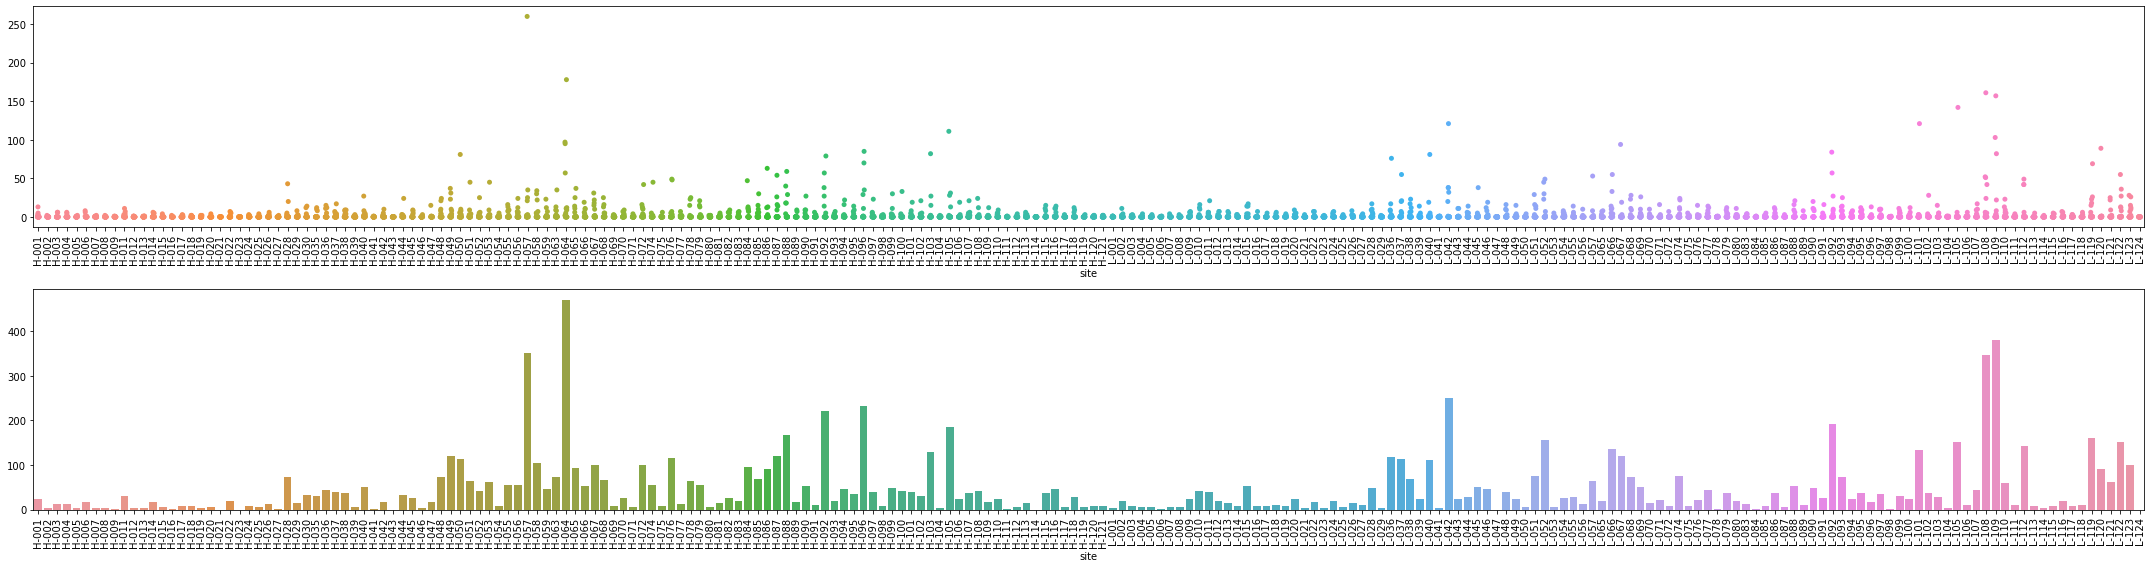

In [99]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, ci=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

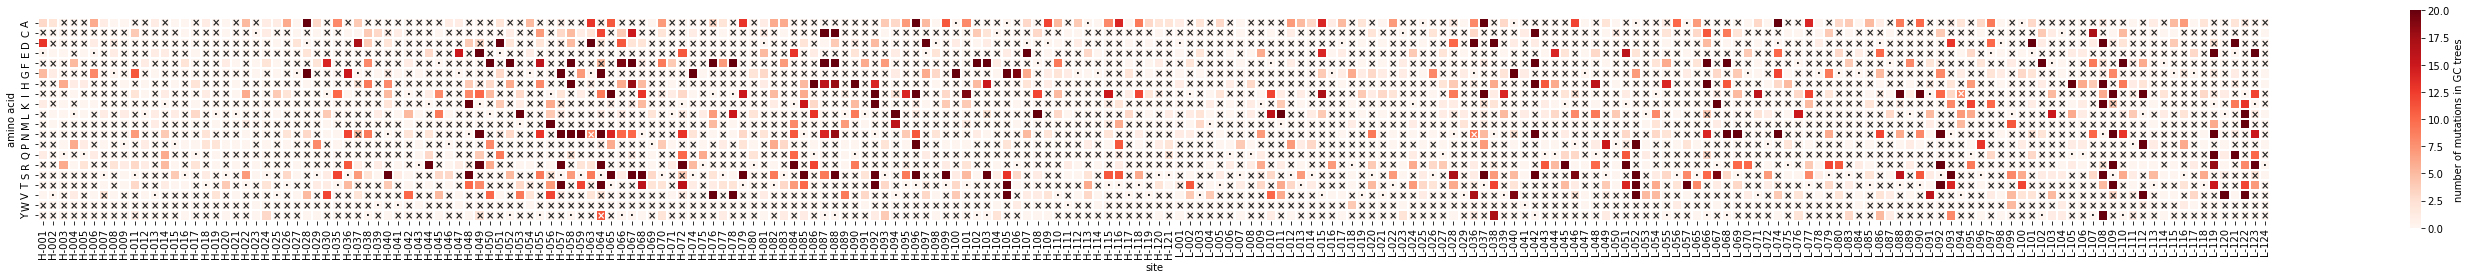

In [102]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, vmin=0, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="Reds",
            vmax=20,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

## To do:
- add heatmap of mutability
- site-wise traces (using Euclidean norm) for each of
 - affinity effect
 - mutation incidence
 - mutability

In [29]:
hits_df.loc["N", "H-057"]

260.0

In [26]:
for gc, tree in trees.items():
    for node in tree.tree.traverse(strategy="preorder"):
        if "S57(H)N" in node.mutations:
            print(gc, node.name)

mouse1_GC1-RP seq46
mouse1_GC1-RP seq40
mouse1_GC1-RP seq23
mouse1_GC1-RP seq10
mouse1_GC1-RP seq12
mouse1_GC1-RP seq54
mouse1_GC1-RP seq13
mouse1_GC1-RP seq72
mouse1_GC1-RP 29
mouse1_GC1-RP seq70
mouse1_GC1-RP seq20
mouse1_GC1-RP seq39
mouse1_GC11-RB seq34
mouse1_GC11-RB seq4
mouse1_GC11-RB seq9
mouse1_GC11-RB seq20
mouse1_GC11-RB seq31
mouse1_GC11-RB seq29
mouse1_GC11-RB seq53
mouse1_GC11-RB seq27
mouse1_GC11-RB seq37
mouse1_GC11-RB seq19
mouse1_GC11-RB seq39
mouse1_GC11-RB seq24
mouse1_GC11-RB seq41
mouse1_GC11-RB seq18
mouse1_GC11-RB 16
mouse1_GC11-RB seq50
mouse1_GC11-RB seq1
mouse1_GC11-RB 26
mouse1_GC11-RB seq32
mouse1_GC11-RB seq21
mouse1_GC11-RB seq40
mouse1_GC11-RB seq33
mouse1_GC11-RB seq51
mouse1_GC11-RB seq35
mouse1_GC11-RB 15
mouse1_GC11-RB seq36
mouse1_GC11-RB seq46
mouse1_GC11-RB seq23
mouse1_GC11-RB 18
mouse1_GC11-RB seq17
mouse1_GC11-RB seq54
mouse1_GC11-RB seq16
mouse1_GC11-RB seq3
mouse1_GC11-RB seq52
mouse1_GC11-RB seq5
mouse1_GC11-RB 27
mouse1_GC11-RB seq38
mouse1